In [1]:
import os
import glob
import shutil
import json
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from keras.preprocessing.image import ImageDataGenerator
import torch
import torch.nn as nn
# Defining the working directories

work_dir = '../input/cassava-leaf-disease-classification/'
os.listdir(work_dir) 
train_path = '/kaggle/input/cassava-leaf-disease-classification/train_images'

2024-02-14 12:03:44.919195: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-14 12:03:44.919281: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-14 12:03:45.047448: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Importing Train Data

data = pd.read_csv(work_dir + 'train.csv')
print(Counter(data['label'])) # Checking the frequencies of the labels

Counter({3: 13158, 4: 2577, 2: 2386, 1: 2189, 0: 1087})


In [3]:
#Importing the json file with labels

f = open(work_dir + 'label_num_to_disease_map.json')
real_labels = json.load(f)
real_labels = {int(k):v for k,v in real_labels.items()}

# Defining the working dataset

data['class_name'] = data.label.map(real_labels)

# Splitting the data

from sklearn.model_selection import train_test_split

train,val = train_test_split(data, test_size = 0.05, random_state = 42, stratify = data['class_name'])

# Importing the data using ImageDataGenerator

IMG_SIZE = 456
size = (IMG_SIZE,IMG_SIZE)
n_CLASS = 5
BATCH_SIZE = 15

datagen_train = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    rotation_range = 40,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    vertical_flip = True,
                    fill_mode = 'nearest')

datagen_val = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    )

train_set = datagen_train.flow_from_dataframe(train,
                             directory = train_path,
                             seed=42,
                             x_col = 'image_id',
                             y_col = 'class_name',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

val_set = datagen_val.flow_from_dataframe(val,
                             directory = train_path,
                             seed=42,
                             x_col = 'image_id',
                             y_col = 'class_name',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

Found 20327 validated image filenames belonging to 5 classes.
Found 1070 validated image filenames belonging to 5 classes.


In [4]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3

model = Sequential()
# initialize the model with input shape
model.add(EfficientNetB3(input_shape = (IMG_SIZE, IMG_SIZE, 3), include_top = False,
                         weights = 'imagenet',
                         drop_connect_rate=0.6))
#for layer in model.layers[:-40]:  # Training just part of the architecture do not optimize the performance
#    layer.trainable = False
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(256, activation = 'relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
model.add(Dropout(0.5))
model.add(Dense(n_CLASS, activation = 'softmax'))

model.summary()

43941136/43941136 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 15, 15, 1536)      10783535  
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                         

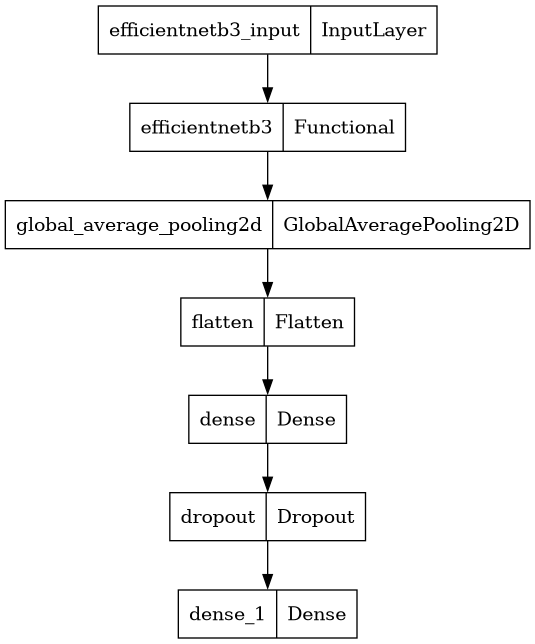

In [6]:
keras.utils.plot_model(model)

In [6]:
EPOCHS = 15
STEP_SIZE_TRAIN = train_set.n//train_set.batch_size
STEP_SIZE_VALID = val_set.n//val_set.batch_size

In [11]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits = False,
                                                   label_smoothing=0.0001,
                                                   name='categorical_crossentropy' )
    
model.compile(optimizer = Adam(learning_rate = 1e-3),
                        loss = loss, #'categorical_crossentropy'
                        metrics = ['categorical_accuracy']) #'acc'

In [10]:
#categorical_accuracy
history = model.fit(train_set,
                             validation_data = val_set,
                             epochs= EPOCHS,
                             batch_size = BATCH_SIZE,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_steps = STEP_SIZE_VALID)

Epoch 1/5


2024-02-10 12:19:28.735630: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1707567577.007050     103 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1355/1355 [==============================] - 1526s 1s/step - loss: 0.7084 - categorical_accuracy: 0.7578 - val_loss: 0.5035 - val_categorical_accuracy: 0.8225
Epoch 2/5
1355/1355 [==============================] - 1362s 1s/step - loss: 0.5431 - categorical_accuracy: 0.8176 - val_loss: 0.7305 - val_categorical_accuracy: 0.7709
Epoch 3/5
1355/1355 [==============================] - 1364s 1s/step - loss: 0.5074 - categorical_accuracy: 0.8326 - val_loss: 0.5417 - val_categorical_accuracy: 0.8169
Epoch 4/5
1355/1355 [==============================] - 1362s 1s/step - loss: 0.4952 - categorical_accuracy: 0.8356 - val_loss: 0.4388 - val_categorical_accuracy: 0.8498
Epoch 5/5
1355/1355 [==============================] - 1363s 1s/step - loss: 0.4687 - categorical_accuracy: 0.8460 - val_loss: 0.4370 - val_categorical_accuracy: 0.8573


In [10]:
# Taylor cross entropy loss
def taylor_cross_entropy_loss(y_pred, y_true, n=3, label_smoothing=0.0):
    """Taylor Cross Entropy Loss.
    Args:
    y_pred: A multi-dimensional probability tensor with last dimension `num_classes`.
    y_true: A tensor with shape and dtype as y_pred.
    n: An order of taylor expansion.
    label_smoothing: A float in [0, 1] for label smoothing.
    Returns:
    A loss tensor.
    """
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.cast(y_true, tf.float32)

    if label_smoothing > 0.0:
        num_classes = tf.cast(tf.shape(y_true)[-1], tf.float32)
        y_true = (1 - num_classes /(num_classes - 1) * label_smoothing) * y_true + label_smoothing / (num_classes - 1)
    
    y_pred_n_order = tf.math.maximum(tf.stack([1 - y_pred] * n), 1e-7) # avoide being too small value
    numerator = tf.math.maximum(tf.math.cumprod(y_pred_n_order, axis=0), 1e-7) # avoide being too small value
    denominator = tf.expand_dims(tf.expand_dims(tf.range(1, n+1, dtype="float32"), axis=1), axis=1)
    y_pred_taylor = tf.math.maximum(tf.math.reduce_sum(tf.math.divide(numerator, denominator), axis=0), 1e-7) # avoide being too small value
    loss_values = tf.math.reduce_sum(y_true * y_pred_taylor, axis=1, keepdims=True)
    return tf.math.reduce_sum(loss_values, -1)

class TaylorCrossEntropyLoss(tf.keras.losses.Loss):
    def __init__(self, n=3, label_smoothing=0.0):
        super(TaylorCrossEntropyLoss, self).__init__()
        self.n = n
        self.label_smoothing = label_smoothing
    
    def call(self, y_true, y_pred):
        return taylor_cross_entropy_loss(y_pred, y_true, n=self.n, label_smoothing=self.label_smoothing)

In [11]:
loss = TaylorCrossEntropyLoss(n=3)
    
model.compile(optimizer = Adam(learning_rate = 1e-3),
                        loss = loss, #'categorical_crossentropy'
                        metrics = ['categorical_accuracy']) #'acc'

In [12]:
#Taylor Cross Entropy
history = model.fit(train_set,
                             validation_data = val_set,
                             epochs= EPOCHS,
                             batch_size = BATCH_SIZE,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_steps = STEP_SIZE_VALID)

Epoch 1/15


2024-02-10 19:00:54.047524: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1707591661.932057     108 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1355/1355 [==============================] - 1374s 962ms/step - loss: 0.7137 - categorical_accuracy: 0.7522 - val_loss: 0.7909 - val_categorical_accuracy: 0.7099
Epoch 2/15
1355/1355 [==============================] - 1141s 842ms/step - loss: 0.5425 - categorical_accuracy: 0.8185 - val_loss: 0.4965 - val_categorical_accuracy: 0.8310
Epoch 3/15
1355/1355 [==============================] - 1152s 850ms/step - loss: 0.5128 - categorical_accuracy: 0.8305 - val_loss: 0.5046 - val_categorical_accuracy: 0.8357
Epoch 4/15
1355/1355 [==============================] - 1158s 854ms/step - loss: 0.4889 - categorical_accuracy: 0.8378 - val_loss: 0.5632 - val_categorical_accuracy: 0.8160
Epoch 5/15
1355/1355 [==============================] - 1147s 846ms/step - loss: 0.4691 - categorical_accuracy: 0.8434 - val_loss: 0.4352 - val_categorical_accuracy: 0.8498
Epoch 6/15
1355/1355 [==============================] - 1130s 834ms/step - loss: 0.4523 - categorical_accuracy: 0.8525 - val_loss: 0.3821 - val_ca

In [17]:
# Evaluate the model on the testing data
loss, accuracy = model.evaluate(val_set)

72/72 [==============================] - 14s 155ms/step - loss: 0.3332 - categorical_accuracy: 0.8897


In [14]:
model.save('Cassava_model_taylor_model'+'.h5')  

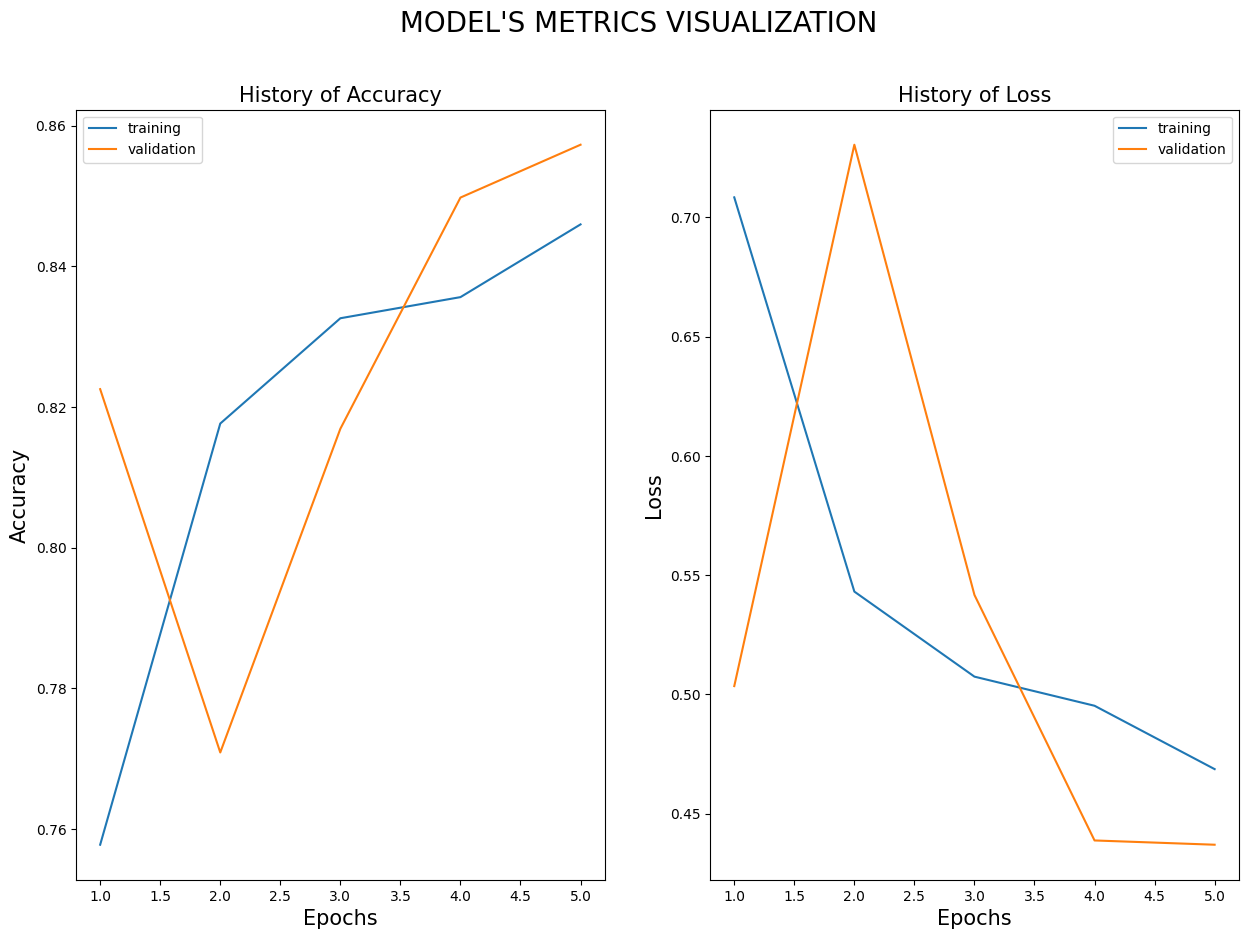

In [19]:
def Train_Val_Plot(acc,val_acc,loss,val_loss):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ", fontsize=20)

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy', fontsize=15)
    ax1.set_xlabel('Epochs', fontsize=15)
    ax1.set_ylabel('Accuracy', fontsize=15)
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss', fontsize=15)
    ax2.set_xlabel('Epochs', fontsize=15)
    ax2.set_ylabel('Loss', fontsize=15)
    ax2.legend(['training', 'validation'])
    plt.show()


Train_Val_Plot(model.history.history['accuracy'],model.history.history['val_accuracy'],
               model.history.history['loss'],model.history.history['val_loss'])

In [16]:
import keras

model = keras.models.load_model('/kaggle/input/cassava-model/Cassava_best_model.h5')

In [9]:
TEST_DIR = '../input/cassava-leaf-disease-classification/test_images/'
test_images = os.listdir(TEST_DIR)
datagen = ImageDataGenerator(horizontal_flip=True)


def pred(images):
    for image in test_images:
        img = Image.open(TEST_DIR + image)
        img = img.resize(size)
        samples = np.expand_dims(img, axis=0)
        it = datagen.flow(samples, batch_size=10)
        yhats = final_model.predict_generator(it, steps=10, verbose=0)
        summed = np.sum(yhats, axis=0)
    return np.argmax(summed)

predictions = pred(test_images)

/tmp/ipykernel_34/3661338316.py:12: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  yhats = final_model.predict_generator(it, steps=10, verbose=0)


In [10]:
# Creating the CSV for final submission

sub = pd.DataFrame({'image_id': test_images, 'label': predictions})
display(sub)
#sub.to_csv('submission.csv', index = False)

,image_id,label
0,2216849948.jpg,4


In [11]:
type(train_set)

keras.src.preprocessing.image.DataFrameIterator

#  Fliping Code

In [ ]:
import numpy as np
import matplotlib.pyplot as plt  

# Get labels and images from iterator 
y_train = train_set.labels  
X_train = np.concatenate([train_set.next()[0] for i in range(len(train_set))])

num_samples = len(y_train)
num_classes = len(np.unique(y_train))

def flip_labels(labels, p):
    flip_indices = np.random.choice(num_samples, size=int(p*num_samples), replace=False) 
    for i in flip_indices:  
        labels[i] = np.random.randint(0,num_classes)
    return labels

accuracies = []

for p in [0.05, 0.1, 0.15, 0.2]:
   
    y_train_flipped = flip_labels(y_train, p)  
    
    model.fit(X_train, y_train_flipped, epochs=1)
    acc = model.evaluate(X_test, y_test)[1]
    
    accuracies.append(acc)
    print(acc,"\n\n\n\n")
    
plt.plot([5, 10, 15, 20], accuracies)
plt.xticks([5, 10, 15, 20])
plt.xlabel('% Flipped Labels') 
plt.ylabel('Test Accuracy')
plt.title('Model Performance vs Flipped Labels')
plt.show()

print("Detailed analysis:")

# Fliping Detection

In [ ]:
import numpy as np
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import Model 

NUM_CLASSES = 5

# Isolation Forest model 
iforest = IsolationForest(n_estimators=100, contamination=0.1)

for epoch in range(epochs):

    # Train epoch
    model.fit(X_train, y_train_flipped)  

    # Get embeddings 
    embeddings_model = Model(inputs=model.input, outputs=model.layers[-2].output)
    embeddings = embeddings_model.predict(X_train)

    # Iterate through each class
    for class_id in range(NUM_CLASSES):

        # Get indices of this class 
        class_indices = np.where(y_train == class_id)[0]
        
        # Clustering analysis
        labels = iforest.fit_predict(embeddings[class_indices])  
        anomalies = class_indices[np.where(labels == -1)[0]]
        
        if len(anomalies) > 0:
            print(f"Anomalous samples detected in class {class_id}: {anomalies}")
            
    # Important clusters printed